In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Pre-treatment

In [ ]:
# Load data from geopackage
gpkg_path = '/content/drive/MyDrive/Colab Notebooks/batrem/batrem_4k.gpkg'
layer_name = 'buildings'
gdf = gpd.read_file(gpkg_path, layer=layer_name)

In [ ]:
# Keep only useful columns
columns = ['id','nature', 'usage1', 'usage2','nb_logts', 'nb_etages','hauteur',
           'superficie','perimetre','indicateur_forme','granularite','convexite',
           'bat_moy_s_500','bat_moy_s_125','bat_moy_s_250','bat_moy_h_500',
           'bat_moy_h_250', 'bat_moy_h_125','remarquable', 'fold']
data = gdf[columns]

In [ ]:
# Set the building ids aside for later use
ids = data['id']
data = data.drop(columns=['id'])

In [ ]:
# Fill empty data with aberrant value (it helps random forest training)
data = data.fillna(9999)

In [ ]:
# Encoding label variables
categorical_columns = ['nature', 'usage1', 'usage2']
data[categorical_columns] = data[categorical_columns].astype(str)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
data_encoded = encoder.fit_transform(data[categorical_columns])
data_encoded = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(categorical_columns))
data = pd.concat([data.drop(categorical_columns, axis=1), data_encoded], axis=1)

In [ ]:
# Check how many differente features have been created
data.shape[1]

38

In [ ]:
# Separate features and target and transform in numpy array for futur operations
X = data.drop('remarquable', axis=1)
y = data['remarquable']
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
# Define PredefinedSplit using the fold column
predefined_split = PredefinedSplit(data['fold'])

In [ ]:
# Check fold balance so we can take their size into account when evaluating data. Fold numbers correspond to spatial areas
for fold_idx, (train_idx, test_idx) in enumerate(predefined_split.split()):
    print(f"Fold {fold_idx + 1}:")
    print(f"Train set: {len(train_idx)} buildings and {np.sum(y[train_idx])} are remarkable")
    print(f"Test set: {len(test_idx)} buildings and {np.sum(y[test_idx])} are remarkable")
    print()

Fold 1: 385 buildings and 98 are remarkable
Fold 2: 1181 buildings and 282 are remarkable
Fold 3: 476 buildings and 75 are remarkable
Fold 4: 619 buildings and 189 are remarkable
Fold 5: 1345 buildings and 377 are remarkable
Fold 6: 510 buildings and 108 are remarkable


In [ ]:
fold_sizes = [385, 1181, 476, 619, 1345, 510]

## Random forest and store metrics

In [ ]:
# Define model
seed=88

model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=350,
    max_depth=15,  # Limit tree depth
    min_samples_split=4,  # Minimum samples required to split a node
    min_samples_leaf=2,  # Minimum samples per leaf node
    max_features='sqrt', # Controls the number of features used for splitting; sqrt is good for classification
    random_state=seed
)

In [ ]:
# Store scoring metrics for each fold
scoring = {'acc_train':[], 'acc_test':[],
           'pre_train':[], 'pre_test':[],
           'rec_train':[], 'rec_test':[],
           'f1_train':[], 'f1_test':[],
           'avg_pre_test':[],
           'roc_auc_test':[]
           }

In [ ]:
# Store interpolated curve values for each fold to later plot ROC and PR curves
interp = np.linspace(0, 1, 100) # x-coordinates at which to evaluate the interpolated values
interp_rocs = []
interp_prs = []

In [ ]:
# Store true labels and predictions across folds to later produce confusion matrix
y_true_combined = []
y_pred_combined = []

In [ ]:
# Perform cross-validation
start_time = time.time()

for fold_idx, (train_idx, test_idx) in enumerate(predefined_split.split()):
    print(f"Fold {fold_idx + 1}")

    # Split the data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Train the model (creates a new ensemble of trees when calling .fit, no need to reboot the model)
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics for this fold on test set and append to scoring
    scoring['acc_test'].append(accuracy_score(y_test, y_pred))
    scoring['pre_test'].append(precision_score(y_test, y_pred))
    scoring['rec_test'].append(recall_score(y_test, y_pred))
    scoring['f1_test'].append(f1_score(y_test, y_pred))
    scoring['avg_pre_test'].append(average_precision_score(y_test, y_pred))

    # Calculate metrics for this fold on train set and append to scoring
    y_train_pred = model.predict(X_train)
    scoring['acc_train'].append(accuracy_score(y_train, y_train_pred))
    scoring['pre_train'].append(precision_score(y_train, y_train_pred))
    scoring['rec_train'].append(recall_score(y_train, y_train_pred))
    scoring['f1_train'].append(f1_score(y_train, y_train_pred))

    # Store predictions and true labels to produce confusion matrix
    y_true_combined.extend(y_test)  # Append true labels
    y_pred_combined.extend(y_pred)  # Append predicted labels

    # Predict probabilities on test set
    y_proba = model.predict_proba(X_test)[:, 1] # retrieve probability to be in the positive class

    ## Compute ROC curve
    scoring['roc_auc_test'].append(roc_auc_score(y_test, y_proba)) # store ROC AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba) # Compute FPR / TPR
    # Interpolate the roc curve (tpr/fpr) to have consistent number of points across folds for later ROC plotting
    interp_roc = np.interp(interp, fpr, tpr)
    interp_rocs.append(interp_roc)

    ## Compute PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    interp_pr = np.interp(interp, recall[::-1], precision[::-1])  # Reverse to ensure monotonic recall
    interp_prs.append(interp_pr)


end_time = time.time()
training_time = end_time - start_time
print(f"Temps d'entraînement : {training_time / 60:.2f} minutes")

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Temps d'entraînement : 0.36 minutes


## Evaluation

In [ ]:
# For each metric, print the score of the six folds on test set
for metric in scoring.keys():
    print(f"Fold scores for {metric}: {scoring[metric]}")

Fold scores for acc_train: [0.9598160251755024, 0.9580209895052474, 0.9571782178217821, 0.962022068257634, 0.967202775149795, 0.9598102845731403]
Fold scores for acc_test: [0.8207792207792208, 0.8044030482641829, 0.7962184873949579, 0.7754442649434572, 0.7665427509293681, 0.8529411764705882]
Fold scores for pre_train: [0.9655543595263725, 0.9608865710560626, 0.9602925809822361, 0.9615384615384616, 0.9628571428571429, 0.9694323144104804]
Fold scores for pre_test: [0.704225352112676, 0.6094420600858369, 0.37209302325581395, 0.8571428571428571, 0.6340425531914894, 0.746268656716418]
Fold scores for rec_train: [0.8700290979631425, 0.8701298701298701, 0.8719165085388995, 0.8776595744680851, 0.8962765957446809, 0.8697355533790402]
Fold scores for rec_test: [0.5102040816326531, 0.5035460992907801, 0.4266666666666667, 0.31746031746031744, 0.3952254641909814, 0.46296296296296297]
Fold scores for f1_train: [0.9153061224489796, 0.9132589838909542, 0.9139731476877175, 0.917686318131257, 0.92837465

In [ ]:
# Print mean scores
for metric in scoring.keys():
    print(f"Mean {metric}: {np.average(scoring[metric])}")

Mean acc_train: 0.9606750600805168
Mean acc_test: 0.802721491463629
Mean pre_train: 0.9634269050617926
Mean pre_test: 0.6538690837508485
Mean rec_train: 0.875957866703953
Mean rec_test: 0.4360109320340602
Mean f1_train: 0.9175801672914118
Mean f1_test: 0.5103941590475802
Mean avg_pre_test: 0.41972196612409846
Mean roc_auc_test: 0.7813816373266911


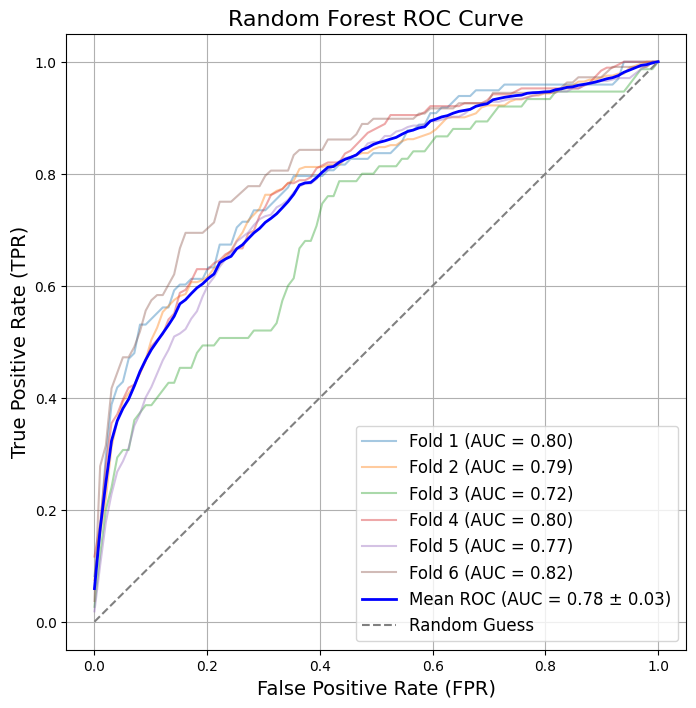

In [ ]:
### Plot ROC curve
plt.figure(figsize=(8, 8))

# Plot individual fold ROC curves
for i, (interp_roc, auc) in enumerate(zip(interp_rocs, scoring['roc_auc_test'])):
    plt.plot(interp, interp_roc, alpha=0.4, label=f'Fold {i+1} (AUC = {auc:.2f})')

# Compute and plot the mean ROC curve and its AUC
mean_roc = np.mean(interp_rocs, axis=0)
mean_roc[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = np.mean(scoring['roc_auc_test'])
std_auc = np.std(scoring['roc_auc_test'])
plt.plot(np.linspace(0, 1, 100), mean_roc, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Finalize the plot
plt.title('Random Forest ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


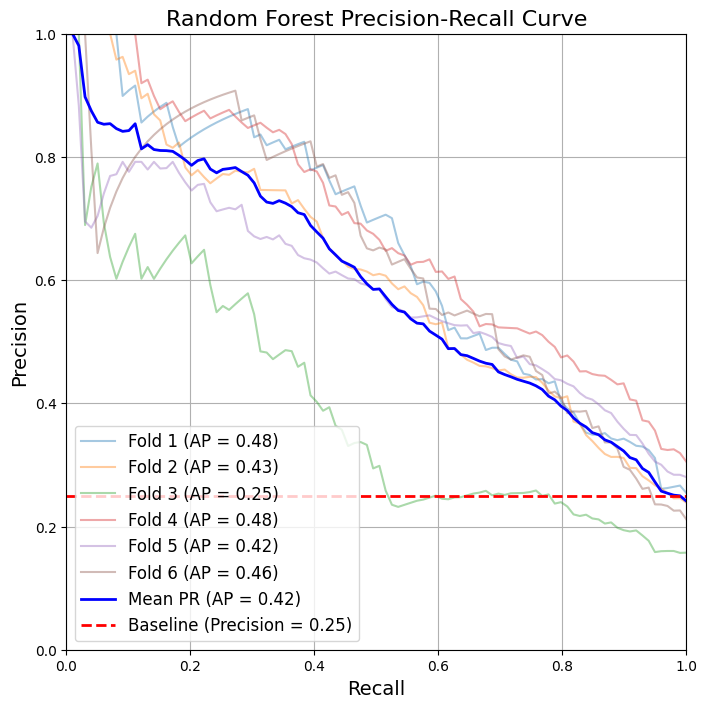

In [ ]:
### Plot the PR curve
plt.figure(figsize=(8, 8))

# Force to display x and y from 0 to 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# Plot individual fold PR curves
for i, interp_pr in enumerate(interp_prs):
    plt.plot(interp, interp_pr, alpha=0.4, label=f'Fold {i+1} (AP = {scoring["avg_pre_test"][i]:.2f})')

# Compute and plot the  mean PR curve
mean_pr = np.mean(interp_prs, axis=0)
mean_avg_precision = np.mean(scoring["avg_pre_test"])
plt.plot(np.linspace(0, 1, 100), mean_pr, color='blue', label=f'Mean PR (AP = {mean_avg_precision:.2f})', lw=2)

# Add the baseline
baseline_precision = 0.25
plt.axhline(y=baseline_precision, color='red', linestyle='--', label=f'Baseline (Precision = {baseline_precision:.2f})', lw=2)

# Finalize the plot
plt.title('Random Forest Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      3387
           1       0.63      0.43      0.51      1129

    accuracy                           0.80      4516
   macro avg       0.73      0.67      0.69      4516
weighted avg       0.78      0.80      0.78      4516



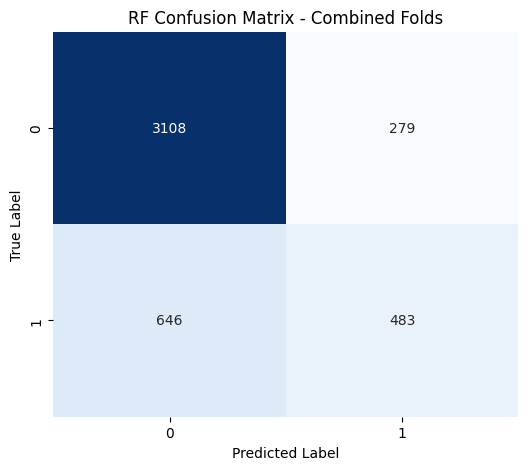

In [ ]:
## Confusion Matrix

# Convert lists to numpy arrays
y_true_combined = np.array(y_true_combined)
y_pred_combined = np.array(y_pred_combined)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_combined, y_pred_combined)

# Print classification report
print("Classification Report:\n", classification_report(y_true_combined, y_pred_combined))

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1],cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("RF Confusion Matrix - Combined Folds")
plt.show()

In [ ]:
## Save predictions on validation sets

# Create an empty list to store IDs for combined predictions
combined_ids = []

# Iterate through folds to get test set indices and corresponding IDs
for fold_idx, (train_idx, test_idx) in enumerate(predefined_split.split()):
    # Append IDs from the test set of this fold to combined_ids
    combined_ids.extend(ids[test_idx]) # we stored ids at the beginning of the project

# Create the DataFrame
results_df = pd.DataFrame({'id': combined_ids, 'y_true': y_true_combined, 'y_pred': y_pred_combined})

# save as results_df as csv
path = '/content/drive/MyDrive/Colab Notebooks/batrem/rf_pred.csv'
results_df.to_csv(path, index=False)